# `Chest X-Ray Pneumonia Detection`

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

## 1) Importing the Dataset

In [4]:
labels = ["PNEUMONIA", "NORMAL"]
img_size = 150


def get_training_data(data_dir):

    data = []
    for label in labels:

        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):

            try:
                img_arr = cv2.imread(os.path.join(
                    path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])

            except Exception as e:
                print(e)

    return np.array(data)

In [5]:
train = get_training_data("./chest_xray/train/")
test = get_training_data("./chest_xray/test/")

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



C:\Users\Admin\AppData\Local\Temp\ipykernel_1916\2762255333.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


#### Stored like: [[image, label], [image, label], [image, label], ...]

## 2) EDA & Data Preprocessing

Text(0.5, 1.0, 'NORMAL')

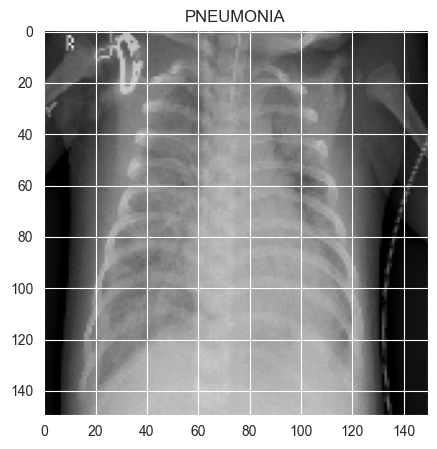

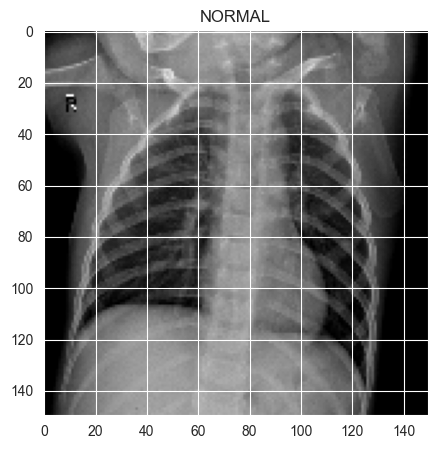

In [13]:
plt.figure(figsize=(5, 5))
plt.imshow(train[0][0], cmap="gray")
plt.title(labels[train[0][1]])

plt.figure(figsize=(5, 5))
plt.imshow(train[-1][0], cmap="gray")
plt.title(labels[train[-1][1]])

In [15]:
X_train = []
y_train = []

X_test = []
y_test = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

### Grayscale Normalization

In [16]:
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255

### Resizing Data

In [18]:
X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## 3) Building the Model

### Model Architecture

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, padding='same',
          activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())

model.add(MaxPool2D((2, 2), strides=2, padding='same'))

model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))

### Compiling the Model

In [39]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_15 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_12 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_16 (Bat  (None, 75, 75, 64)      

In [41]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor="accuracy", patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [42]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=4,
                    callbacks=[learning_rate_reduction])

Epoch 1/4
164/164 [==============================] - 116s 697ms/step - loss: 0.3924 - accuracy: 0.8939 - lr: 0.0010
Epoch 2/4
164/164 [==============================] - 113s 689ms/step - loss: 0.1361 - accuracy: 0.9530 - lr: 0.0010
Epoch 3/4
164/164 [==============================] - 104s 632ms/step - loss: 0.0933 - accuracy: 0.9713 - lr: 0.0010
Epoch 4/4
164/164 [==============================] - 103s 631ms/step - loss: 0.0819 - accuracy: 0.9778 - lr: 0.0010


## 4) Evaluating the Model

In [46]:
print("Loss of the model is - ", model.evaluate(X_test, y_test)[0])
print("Accuracy of the model is - ", model.evaluate(X_test, y_test)[1]*100, "%")

20/20 [==============================] - 3s 117ms/step - loss: 10.4169 - accuracy: 0.6282
Loss of the model is -  10.416890144348145
20/20 [==============================] - 2s 117ms/step - loss: 10.4169 - accuracy: 0.6282
Accuracy of the model is -  62.82051205635071 %


In [47]:
predictions = model.predict(X_test) > 0.5
predictions = predictions.reshape(1, -1)[0]
predictions[:10]

20/20 [==============================] - 2s 121ms/step


array([False, False, False, False, False, False, False, False, False,
       False])

In [48]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[390   0]
 [232   2]]
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       390
           1       1.00      0.01      0.02       234

    accuracy                           0.63       624
   macro avg       0.81      0.50      0.39       624
weighted avg       0.77      0.63      0.49       624



<AxesSubplot: >

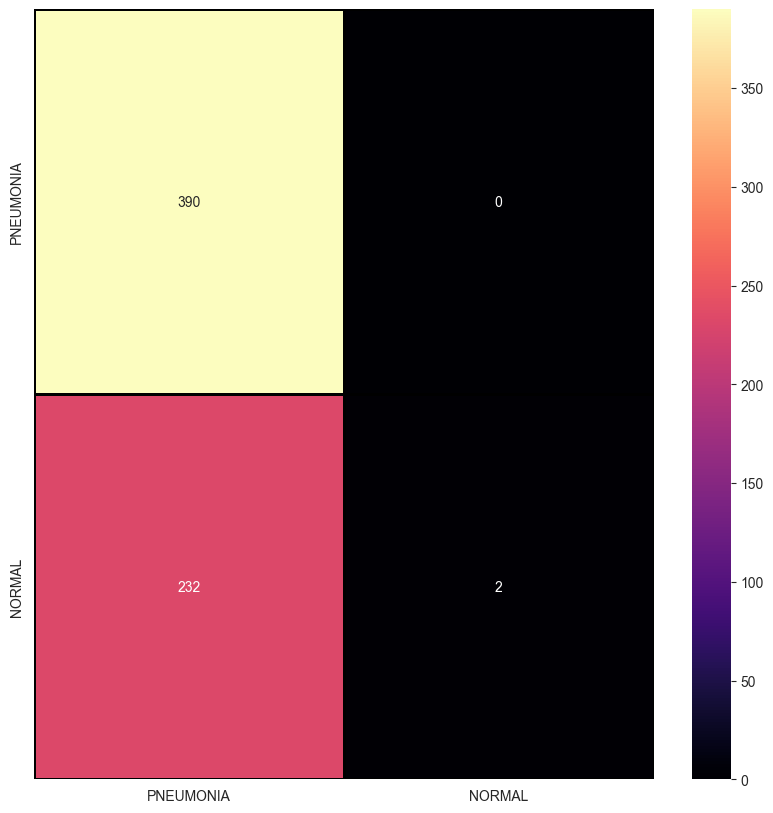

In [49]:
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, index=["0", "1"], columns=["0", "1"])

plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="magma", linecolor='black', linewidth=1,
            annot=True, fmt='', xticklabels=labels, yticklabels=labels)